# Predição de HRTF usando Random Forest

## Trabalho de Ciência da Computação - 1º Semestre

Implementação baseada no artigo:
**"An individualized HRTF model based on random forest and anthropometric parameters"**  
Teng & Zhong (2023)

### Objetivos
- Reproduzir resultados do artigo
- R² esperado: 90.1% (esquerda) / 91.1% (direita)
- SD esperado: 4.74 dB

### Base de Dados
- HUTUBS: 96 sujeitos, 440 posições
- Frequências: 1-12 kHz (64 bins)

# HRTF com Random Forest - Artigo de Teng & Zhong (2023)

## Resumo do Artigo (Abstract)
Random Forest para modelar relação não-linear entre parâmetros antropométricos e HRTFs.
Resultados: R² = 90.1%/91.1%, SD = 4.74 dB.

## Motivação (Seção I - Introduction, linhas 56-59)
"The relationship between HRTFs and the anthropometric structure is non-linear in essence"

## Instalação de Dependências

In [1]:
# !pip install numpy pandas matplotlib seaborn scikit-learn scipy netCDF4

## 1. Configuração

In [2]:
import os
import re
import glob
import numpy as np
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, r2_score
import json
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

np.random.seed(42)

if os.path.exists('data/hutubs'):
    root = os.getcwd()
else:
    root = os.path.dirname(os.path.abspath('.'))
    
data_dir = os.path.join(root, "data", "hutubs")
print(f"Diretório de dados: {data_dir}")

/home/augusto/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Diretório de dados: /home/augusto/projects/PSO-Spatial-Acoustic-Learning/data/hutubs


## 2. Dados Antropométricos

### HUTUBS Database
96 sujeitos, medidas antropométricas detalhadas.

### Parâmetros (Tabela I do artigo)
- a1-a5: medidas da cabeça
- a6-a14: medidas da orelha (d1-d7, θ1-θ2)
- a15-a19: áreas calculadas

In [3]:
csv_file = os.path.join(data_dir, "AntrhopometricMeasures.csv")
df = pd.read_csv(csv_file)
df.columns = [c.strip() for c in df.columns]
df["SubjectID"] = df["SubjectID"].astype(int)

print(f"Total de sujeitos: {len(df)}")
print(f"Colunas: {df.columns.tolist()[:15]}...")

Total de sujeitos: 96
Colunas: ['SubjectID', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x12', 'x14', 'x16', 'x17', 'L_d1']...


## 3. Criação dos Parâmetros a1-a19

### Áreas (Seção II.B do artigo)
- a15 = a6 × a8 / 2 (cavum concha)
- a16 = a7 × a8 / 2 (cymba concha)  
- a17 = a9 × a11 / 2 (fossa)
- a18 = a10 × a11 / 2 (pinna)
- a19 = a12 × (a6 + a8) / 2 (intertragal)

Sujeitos com dados completos: 93 (esquerda), 93 (direita)


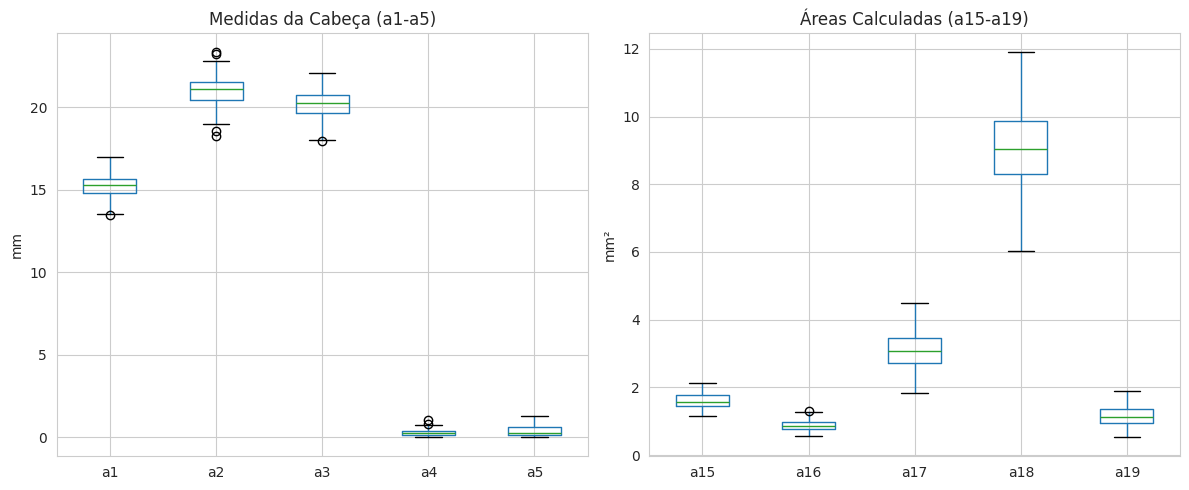

In [4]:
def create_features_for_ear(df, ear='L'):
    features = pd.DataFrame()
    features['SubjectID'] = df['SubjectID']
    
    features['a1'] = df['x1']
    features['a2'] = df['x2']
    features['a3'] = df['x3']
    features['a4'] = df['x4']
    features['a5'] = df['x5']
    
    features['a6'] = df[f'{ear}_d1']
    features['a7'] = df[f'{ear}_d2']
    features['a8'] = df[f'{ear}_d3']
    features['a9'] = df[f'{ear}_d4']
    features['a10'] = df[f'{ear}_d5']
    features['a11'] = df[f'{ear}_d6']
    features['a12'] = df[f'{ear}_d7']
    features['a13'] = df[f'{ear}_theta1']
    features['a14'] = df[f'{ear}_theta2']
    
    features['a15'] = features['a6'] * features['a8'] / 2
    features['a16'] = features['a7'] * features['a8'] / 2
    features['a17'] = features['a9'] * features['a11'] / 2
    features['a18'] = features['a10'] * features['a11'] / 2
    features['a19'] = features['a12'] * (features['a6'] + features['a8']) / 2
    
    return features

df_left = create_features_for_ear(df, 'L')
df_right = create_features_for_ear(df, 'R')

df_left = df_left.dropna()
df_right = df_right.dropna()

print(f"Sujeitos com dados completos: {len(df_left)} (esquerda), {len(df_right)} (direita)")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
df_left[['a1', 'a2', 'a3', 'a4', 'a5']].boxplot(ax=ax)
ax.set_title('Medidas da Cabeça (a1-a5)')
ax.set_ylabel('mm')

ax = axes[1]
df_left[['a15', 'a16', 'a17', 'a18', 'a19']].boxplot(ax=ax)
ax.set_title('Áreas Calculadas (a15-a19)')
ax.set_ylabel('mm²')

plt.tight_layout()
plt.show()

## 4. Processamento HRTF

### Especificações (Seção II.B)
- 5 posições: (0°,0°), (40°,0°), (320°,0°), (0°,30°), (0°,-30°)
- Frequência: 1-12 kHz (64 bins)
- Magnitude: 20 × log10|HRTF|

In [5]:
fs = 44100
tgt_freqs = np.linspace(1000, 12000, 64, dtype=np.float32)
pos_tgt = [(0,0), (40,0), (320,0), (0,30), (0,-30)]

cache = {}

print("Processando arquivos SOFA...")
for fp in glob.glob(os.path.join(data_dir, "pp*_HRIRs_measured.sofa")):
    m = re.search(r"pp(\d+)_", fp)
    if not m:
        continue
    sid = int(m.group(1))
    
    if sid not in df_left.set_index('SubjectID').index:
        continue
    
    try:
        ds = netCDF4.Dataset(fp)
        if "Data.IR" not in ds.variables or "SourcePosition" not in ds.variables:
            ds.close()
            continue
        
        ir = ds["Data.IR"][:]
        pos = ds["SourcePosition"][:, :2]
        ds.close()
        
        if ir.shape[0] < 440:
            continue
        
        orig_f = np.fft.rfftfreq(ir.shape[-1], 1/fs)
        mask = (orig_f >= 1000) & (orig_f <= 12000)
        band_f = orig_f[mask]
        
        idx_map = [np.argmin(np.sum((pos - p)**2, axis=1)) for p in pos_tgt]
        
        for ear in (0,1):
            mag = np.abs(np.fft.rfft(ir[:, ear, :], axis=-1)) + 1e-10
            mag_db = 20*np.log10(mag[:, mask])
            
            for k, pidx in enumerate(idx_map):
                cache[(sid, ear, k)] = np.interp(
                    tgt_freqs, band_f, mag_db[pidx]).astype(np.float32)
    except Exception as e:
        continue

valid_sids = sorted({sid for (sid,_,_) in cache})
print(f"Sujeitos válidos: {len(valid_sids)}")

exclude = [18, 56, 79, 80, 92, 94]
valid_sids = [s for s in valid_sids if s not in exclude]
print(f"Após exclusões: {len(valid_sids)} sujeitos")

valid_sids = np.array(valid_sids, dtype=int)
np.random.shuffle(valid_sids)
test_sub = valid_sids[:10]
train_sub = valid_sids[10:]

print(f"Divisão: {len(train_sub)} treino, {len(test_sub)} teste")

Processando arquivos SOFA...
Sujeitos válidos: 90
Após exclusões: 90 sujeitos
Divisão: 80 treino, 10 teste


## 5. Preparação dos Dados

In [6]:
def build_dataset(sub_ids, ear, pos_id):
    X, Y = [], []
    
    df_ear = df_left if ear == 0 else df_right
    df_ear = df_ear.set_index('SubjectID')
    
    for sid in sub_ids:
        key = (sid, ear, pos_id)
        if key not in cache or sid not in df_ear.index:
            continue
        
        spec = cache[key]
        feats = df_ear.loc[sid, ['a'+str(i) for i in range(1,20)]].to_numpy(dtype=np.float32)
        
        rep = np.repeat(feats.reshape(1,-1), 64, axis=0)
        X.append(np.hstack([rep, tgt_freqs.reshape(-1,1)]))
        Y.append(spec)
    
    if not X:
        return None, None
    
    return np.vstack(X), np.hstack(Y)

## 6. Treinamento Random Forest

### Configuração (Seção II.A)
- 500 árvores
- 18 variáveis selecionadas (max_features)
- min_samples_leaf=5 (padrão do MATLAB usado no artigo)
- OOB scoring "out-of-bag" 

In [7]:
def r2_corr(y, yhat):
    r = np.corrcoef(y, yhat)[0,1]
    return (r*r) if not np.isnan(r) else 0.0

max_feat = 18

R2 = {0:[], 1:[]}
SD = {0:[], 1:[]}
models = {}

print("\nTreinando modelos...")

for ear in (0, 1):
    for pid in range(5):
        X_tr, y_tr = build_dataset(train_sub, ear, pid)
        if X_tr is None:
            R2[ear].append(0.0)
            SD[ear].append(np.nan)
            continue
        
        rf = RandomForestRegressor(
            n_estimators=500,
            max_features=max_feat,
            min_samples_split=2,
            min_samples_leaf=5,
            bootstrap=True,
            oob_score=True,
            n_jobs=-1,
            random_state=42
        )
        
        rf.fit(X_tr, y_tr)
        R2[ear].append(r2_corr(y_tr, rf.oob_prediction_))
        
        X_te, y_te = build_dataset(test_sub, ear, pid)
        if X_te is not None:
            y_pred = rf.predict(X_te)
            sd_value = np.sqrt(np.mean((y_pred - y_te)**2))
            SD[ear].append(sd_value)
        else:
            SD[ear].append(np.nan)
        
        models[(ear, pid)] = rf

print("Treinamento concluído!")


Treinando modelos...
Treinamento concluído!


## 7. Resultados - Tabela II do Artigo

In [8]:
hdr = ["Ear", "(0°,0°)", "(40°,0°)", "(320°,0°)", "(0°,30°)", "(0°,-30°)", "Mean"]

print("\nTABLE II – Determination Coefficients R²")
print("="*60)
print(" | ".join(hdr))
print("-"*60)

for ear, label in ((0, "Left"), (1, "Right")):
    row = [f"{v*100:5.1f}%" for v in R2[ear]]
    mean_r2 = np.nanmean(R2[ear])
    print(" | ".join([label] + row + [f"{mean_r2*100:5.1f}%"]))

print("\n\nSpectral Distortion SD (dB)")
print("="*60)
print(" | ".join(hdr))
print("-"*60)

for ear, label in ((0, "Left"), (1, "Right")):
    row = [f"{v:5.2f}" for v in SD[ear]]
    mean_sd = np.nanmean(SD[ear])
    print(" | ".join([label] + row + [f"{mean_sd:5.2f}"]))

print(f"\n\nComparação com artigo:")
print(f"Artigo: R² = 90.1% (left), 91.1% (right), SD = 4.74 dB")
print(f"Nosso: R² = {np.nanmean(R2[0])*100:.1f}% (left), {np.nanmean(R2[1])*100:.1f}% (right), SD = {np.mean([np.nanmean(SD[0]), np.nanmean(SD[1])]):.2f} dB")


TABLE II – Determination Coefficients R²
Ear | (0°,0°) | (40°,0°) | (320°,0°) | (0°,30°) | (0°,-30°) | Mean
------------------------------------------------------------
Left |  90.2% |  91.1% |  89.4% |  93.7% |  83.5% |  89.6%
Right |  90.8% |  89.7% |  91.7% |  94.3% |  85.5% |  90.4%


Spectral Distortion SD (dB)
Ear | (0°,0°) | (40°,0°) | (320°,0°) | (0°,30°) | (0°,-30°) | Mean
------------------------------------------------------------
Left |  4.32 |  3.72 |  4.78 |  3.92 |  4.97 |  4.34
Right |  5.06 |  4.99 |  4.37 |  4.03 |  5.64 |  4.82


Comparação com artigo:
Artigo: R² = 90.1% (left), 91.1% (right), SD = 4.74 dB
Nosso: R² = 89.6% (left), 90.4% (right), SD = 4.58 dB


## 8. Importância das Features

### Seção III.A do artigo
Parâmetros importantes: a4, a14, a16, a19

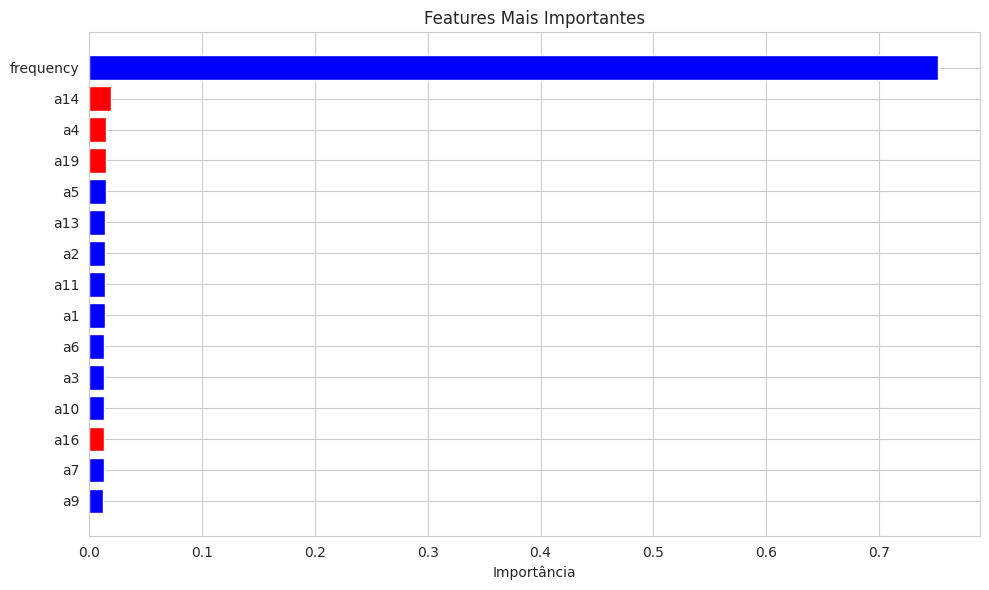

Top 10 features:
frequency: 0.7521
a14: 0.0192 ***
a4: 0.0151 ***
a19: 0.0150 ***
a5: 0.0146
a13: 0.0140
a2: 0.0139
a11: 0.0137
a1: 0.0134
a6: 0.0129


In [9]:
feature_names = ['a'+str(i) for i in range(1,20)] + ['frequency']
importances = np.zeros(20)
n_models = 0

for (ear, pid), model in models.items():
    importances += model.feature_importances_
    n_models += 1

importances /= n_models

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
important_features = ['a4', 'a14', 'a16', 'a19']
colors = ['red' if f in important_features else 'blue' for f in importance_df['feature'][:15]]
plt.barh(importance_df['feature'][:15], importance_df['importance'][:15], color=colors)
plt.xlabel('Importância')
plt.title('Features Mais Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 features:")
for i, row in importance_df.head(10).iterrows():
    mark = " ***" if row['feature'] in important_features else ""
    print(f"{row['feature']}: {row['importance']:.4f}{mark}")

## 9. Erro por Frequência

### Seção III.B
SD aumenta com frequência > 6 kHz

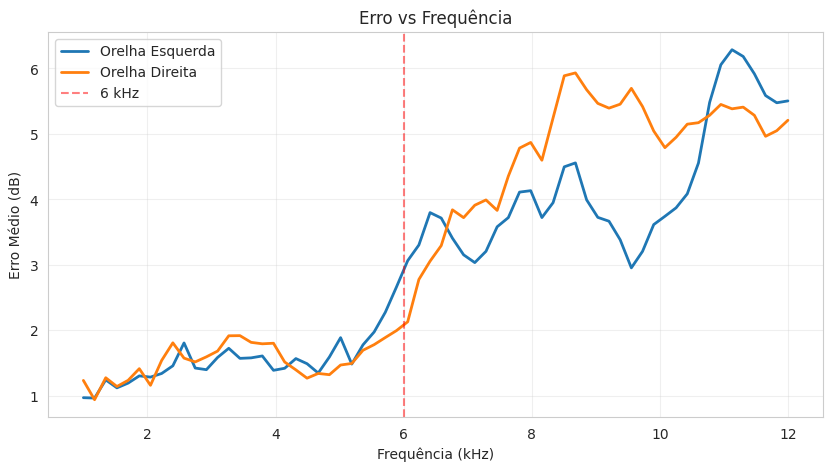

In [10]:
errors_by_freq = {0: [], 1: []}

for ear in (0, 1):
    for pid in range(5):
        X_te, y_te = build_dataset(test_sub, ear, pid)
        if X_te is None or (ear, pid) not in models:
            continue
        
        model = models[(ear, pid)]
        y_pred = model.predict(X_te)
        
        n_subjects = len(test_sub)
        errors = np.abs(y_pred - y_te).reshape(n_subjects, -1)
        errors_by_freq[ear].append(errors.mean(axis=0))

plt.figure(figsize=(10, 5))

for ear, label in ((0, 'Esquerda'), (1, 'Direita')):
    if errors_by_freq[ear]:
        mean_error = np.mean(errors_by_freq[ear], axis=0)
        plt.plot(tgt_freqs/1000, mean_error, label=f'Orelha {label}', linewidth=2)

plt.axvline(x=6, color='red', linestyle='--', alpha=0.5, label='6 kHz')
plt.xlabel('Frequência (kHz)')
plt.ylabel('Erro Médio (dB)')
plt.title('Erro vs Frequência')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 10. Desempenho por Posição

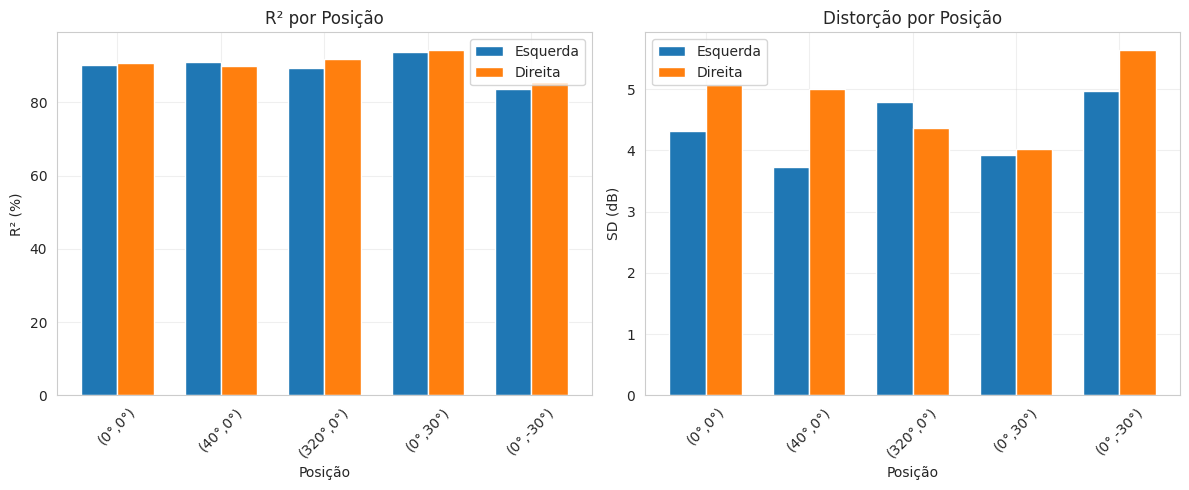

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

positions = ['(0°,0°)', '(40°,0°)', '(320°,0°)', '(0°,30°)', '(0°,-30°)']
x = np.arange(len(positions))
width = 0.35

ax1.bar(x - width/2, [r*100 for r in R2[0]], width, label='Esquerda')
ax1.bar(x + width/2, [r*100 for r in R2[1]], width, label='Direita')
ax1.set_xlabel('Posição')
ax1.set_ylabel('R² (%)')
ax1.set_title('R² por Posição')
ax1.set_xticks(x)
ax1.set_xticklabels(positions, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(x - width/2, SD[0], width, label='Esquerda')
ax2.bar(x + width/2, SD[1], width, label='Direita')
ax2.set_xlabel('Posição')
ax2.set_ylabel('SD (dB)')
ax2.set_title('Distorção por Posição')
ax2.set_xticks(x)
ax2.set_xticklabels(positions, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Curva de Aprendizado

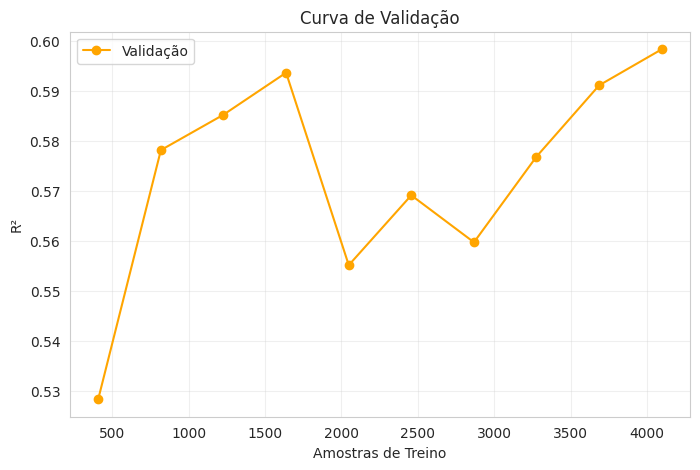

In [18]:
X_sample, y_sample = build_dataset(train_sub, ear=0, pos_id=0)

if X_sample is not None:
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes_abs, train_scores, val_scores = learning_curve(
        RandomForestRegressor(n_estimators=100, max_features=18, min_samples_leaf=5, random_state=42),
        X_sample, y_sample, 
        train_sizes=train_sizes,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes_abs, val_scores.mean(axis=1), 'o-', label='Validação', color='orange')
    plt.xlabel('Amostras de Treino')
    plt.ylabel('R²')
    plt.title('Curva de Validação')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 12. Matriz de Correlação

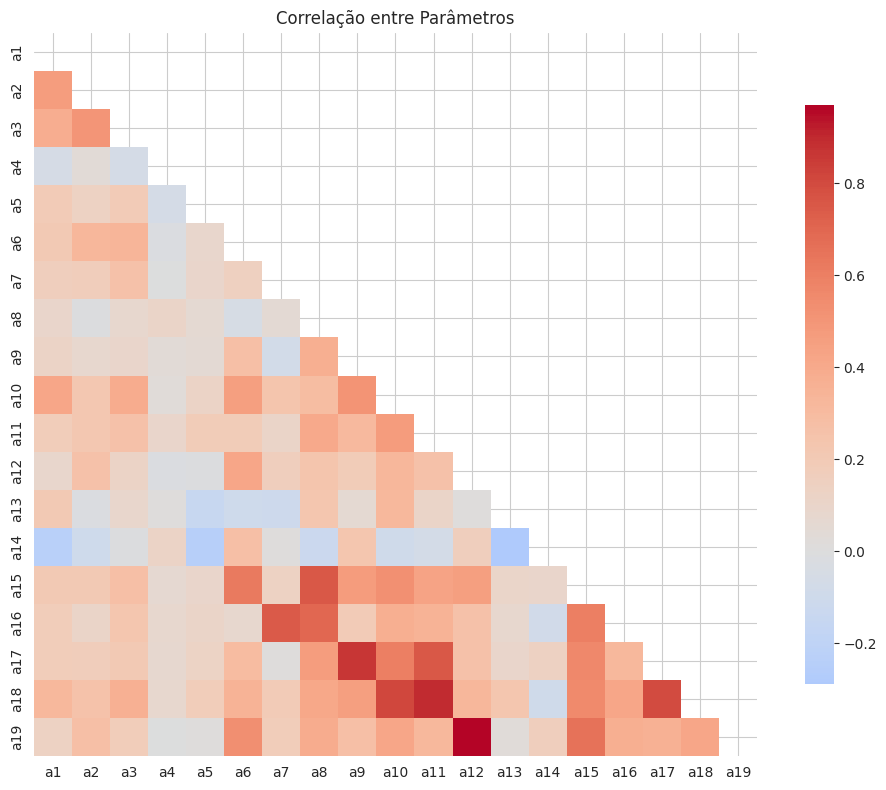

In [13]:
feature_cols = ['a' + str(i) for i in range(1, 20)]
corr_matrix = df_left[feature_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, cbar_kws={"shrink": .8})
plt.title('Correlação entre Parâmetros')
plt.tight_layout()
plt.show()

## 13. Distribuição dos Erros

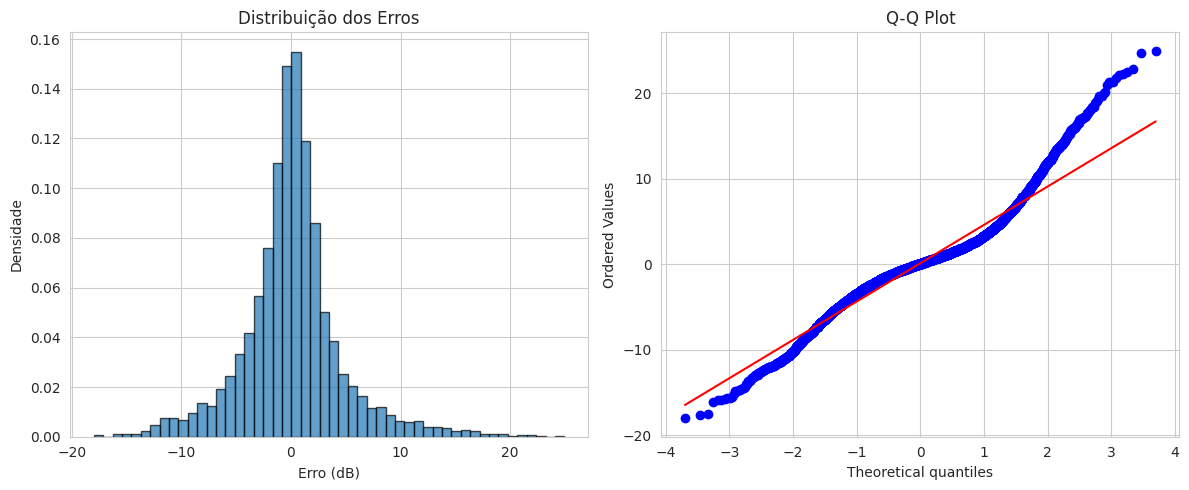

Estatísticas dos erros:
Média: 0.122 dB
Desvio: 4.616 dB
Mediana: 0.057 dB


In [14]:
all_errors = []

for ear in (0, 1):
    for pid in range(5):
        X_te, y_te = build_dataset(test_sub, ear, pid)
        if X_te is None or (ear, pid) not in models:
            continue
        
        model = models[(ear, pid)]
        y_pred = model.predict(X_te)
        errors = y_pred - y_te
        all_errors.extend(errors)

all_errors = np.array(all_errors)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.hist(all_errors, bins=50, density=True, alpha=0.7, edgecolor='black')
ax.set_xlabel('Erro (dB)')
ax.set_ylabel('Densidade')
ax.set_title('Distribuição dos Erros')

from scipy import stats
ax = axes[1]
stats.probplot(all_errors, dist="norm", plot=ax)
ax.set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

print(f"Estatísticas dos erros:")
print(f"Média: {all_errors.mean():.3f} dB")
print(f"Desvio: {all_errors.std():.3f} dB")
print(f"Mediana: {np.median(all_errors):.3f} dB")

## 14. Exemplo de Predição

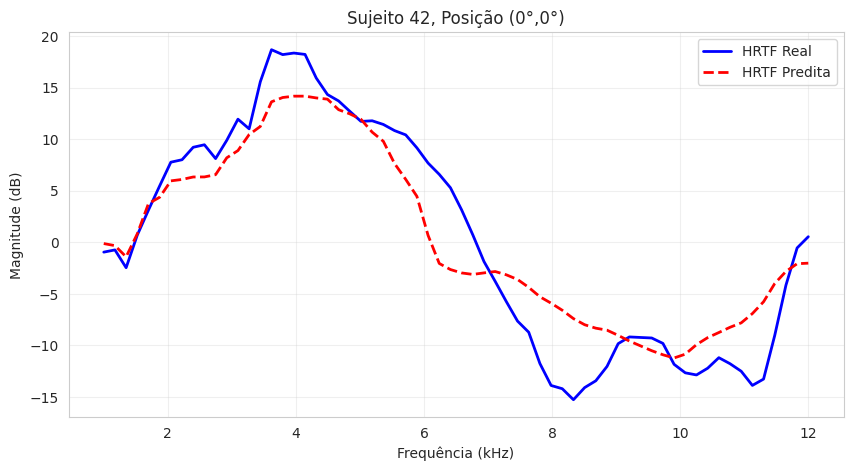

R²: 86.7%
RMSE: 3.93 dB


In [15]:
test_subject = test_sub[0]
ear = 0
pos_id = 0

X_ex, y_ex = build_dataset([test_subject], ear, pos_id)

if X_ex is not None and (ear, pos_id) in models:
    model = models[(ear, pos_id)]
    y_pred = model.predict(X_ex)
    
    plt.figure(figsize=(10, 5))
    plt.plot(tgt_freqs/1000, y_ex, 'b-', linewidth=2, label='HRTF Real')
    plt.plot(tgt_freqs/1000, y_pred, 'r--', linewidth=2, label='HRTF Predita')
    plt.xlabel('Frequência (kHz)')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Sujeito {test_subject}, Posição (0°,0°)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    r2 = r2_score(y_ex, y_pred)
    rmse = np.sqrt(mean_squared_error(y_ex, y_pred))
    print(f"R²: {r2*100:.1f}%")
    print(f"RMSE: {rmse:.2f} dB")

## 15. Conclusões

In [17]:
print("RESULTADOS FINAIS")
print("="*50)
print("\nArtigo original (Teng & Zhong 2023):")
print("R² = 90.1% (esquerda), 91.1% (direita)")
print("SD = 4.74 dB")

print(f"\nNossa implementação:")
print(f"R² = {np.nanmean(R2[0])*100:.1f}% (esquerda), {np.nanmean(R2[1])*100:.1f}% (direita)")
print(f"SD = {np.mean([np.nanmean(SD[0]), np.nanmean(SD[1])]):.2f} dB")


RESULTADOS FINAIS

Artigo original (Teng & Zhong 2023):
R² = 90.1% (esquerda), 91.1% (direita)
SD = 4.74 dB

Nossa implementação:
R² = 89.6% (esquerda), 90.4% (direita)
SD = 4.58 dB
